In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import scipy.io
import dataset.precomp_dataset as ds
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import utils.psf_utils as psf_utils
import train
import PIL.Image as Image
import numpy as np, torch
import os, tqdm
import glob

# Change this to GPU or CPU depending on your machine 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = "cuda:2"

%load_ext autoreload
%autoreload 2

if "cuda" in device:
    print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


## Initialize model

In [64]:
psf_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
calib_mat_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [256, 256]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements

config = {
    "device": device,
    "mask_dir": calib_mat_path,
    "psf_dir": psf_path,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures[:stack_depth*blurstride:blurstride],
            "w_init": w_init,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": True,
            "adjoint": False,
            "spectral_pad": False,
            "roll": True
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 400,
        "prox_method": 'tv',
        "tau": 0.5,
        "tv_lambda": 0.501,
        "tv_lambdaw": 0.001,
        "tv_lambdax": 10,
        "lowrank_lambda": 0.4,
        "print_every": 390
    },
    "batch_size": 1,
    "data_partition": ["harvard", "fruit", "pavia"],
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

model = train.get_model(config, device=device)

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 42.13it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
cuda:2


## Load simulation data

In [60]:
config["base_data_path"] = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data_preprocessed/sample_data_preprocessed_lri"
train_loader, val_loader, test_loader = ds.get_data_precomputed(
    batch_size=config["batch_size"],
    data_split=config["data_partition"],
    base_path=config["base_data_path"],
    model_params=config["forward_model_params"],
    workers = 6,
)
gt = val_loader.dataset[0]['image']
gt = (gt - torch.min(gt))/(torch.max(gt-torch.min(gt)))

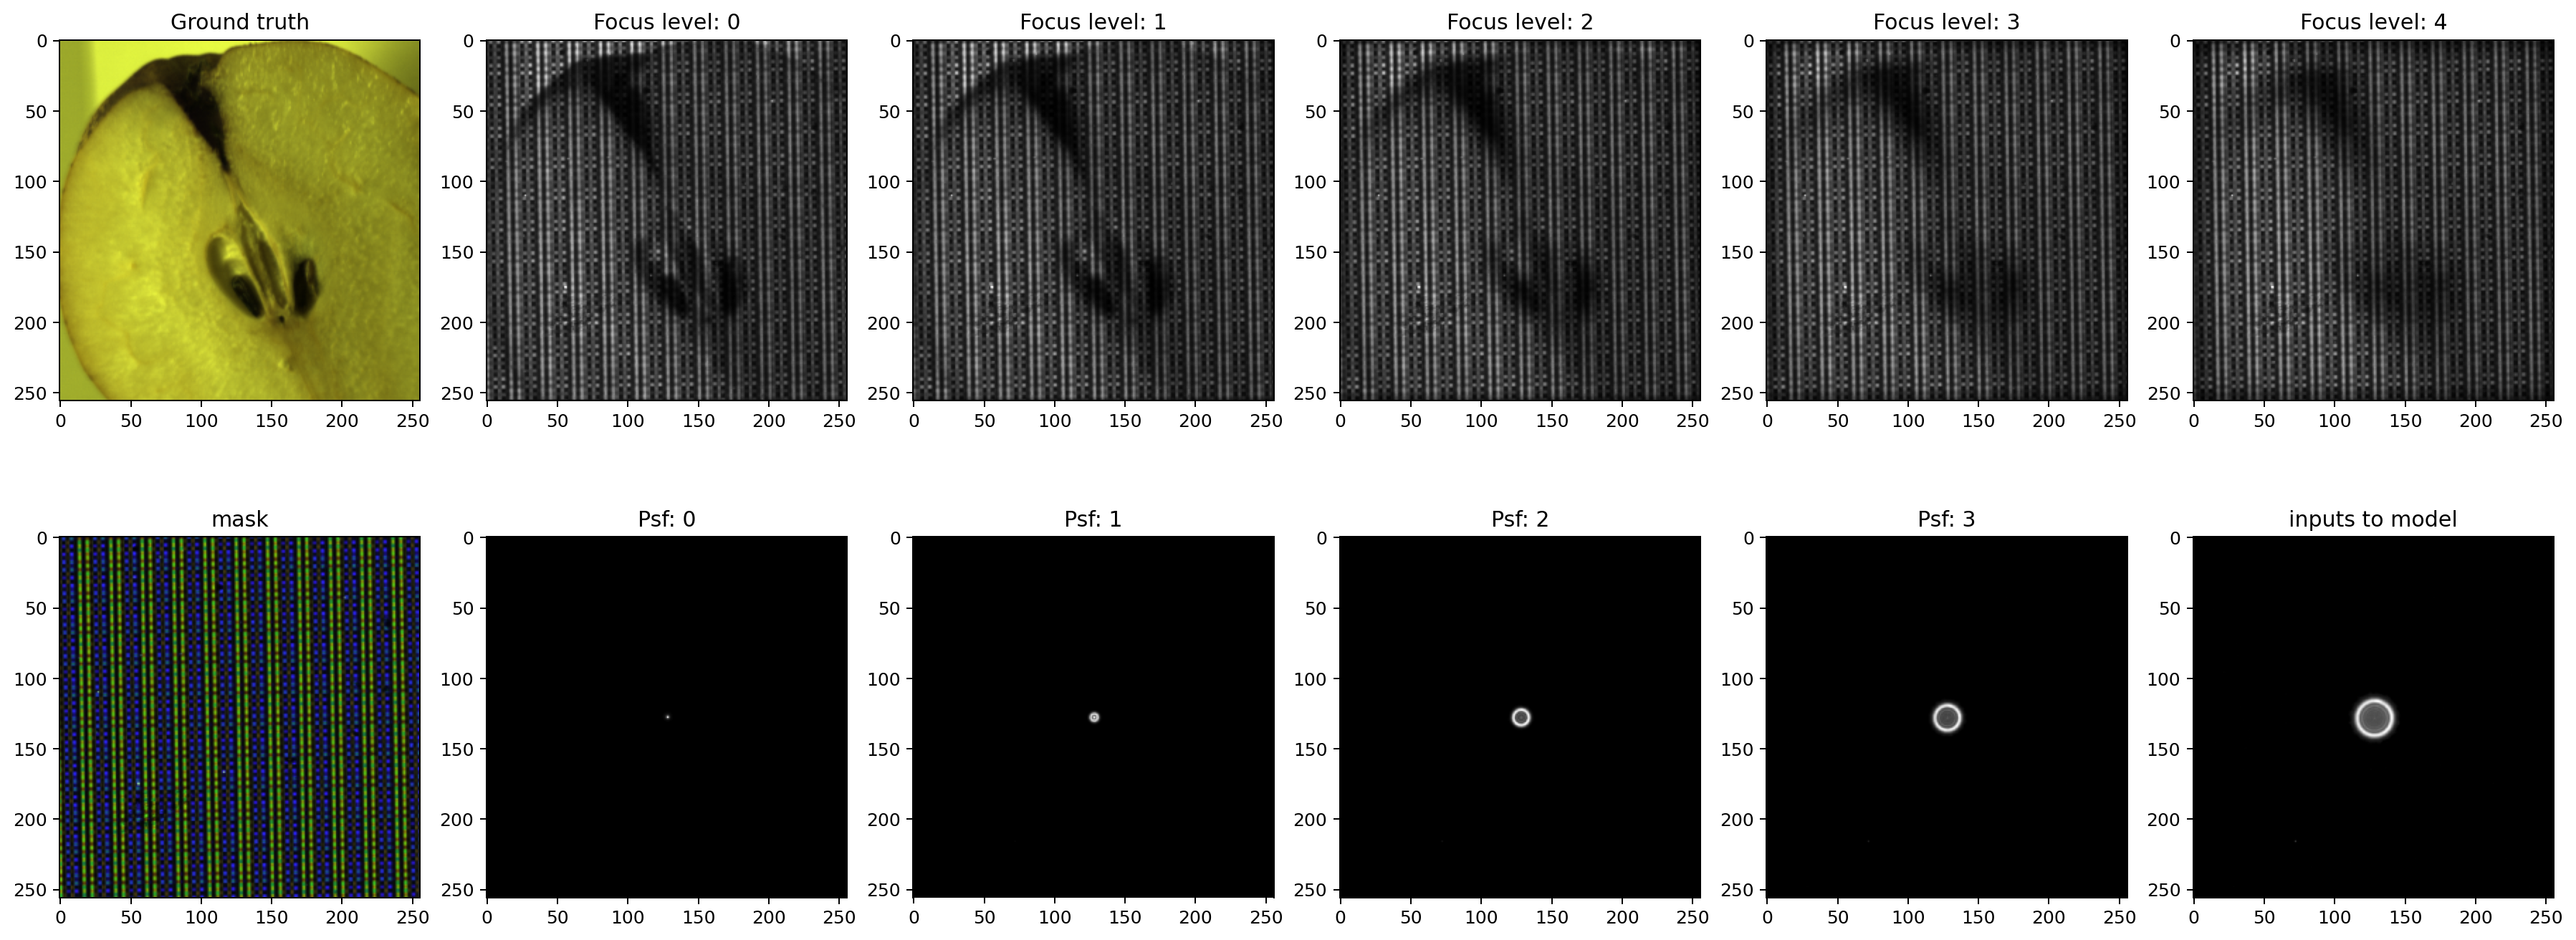

In [61]:
sim_meas = model.model1(gt.to(device)[None,None,...])

plot = lambda x: helper.value_norm(helper.stack_rgb_opt_30(np.transpose(x, (1,2,0))))
fig, ax = plt.subplots(2, len(sim_meas[0])+1, figsize = (4*len(sim_meas[0]), 8))
fig.set_dpi(180)
for i in range(len(sim_meas[0])+1):
    if i == 0:
        ax[0][i].imshow(plot(gt.cpu().numpy()))
        ax[0][i].set_title(f"Ground truth")
        ax[1][i].imshow(plot(model.model1.mask[0].cpu().numpy()))
        ax[1][i].set_title(f"mask")
    else:
        ax[0][i].imshow(np.mean(sim_meas[0,i-1].cpu().numpy(), 0), cmap='gray')
        ax[0][i].set_title(f"Focus level: {i-1}")
        ax[1][i].imshow(model.model1.psfs[i-1].cpu().numpy(), cmap='gray')
        ax[1][i].set_title(f"Psf: {i-1}")
plt.title("inputs to model")
plt.tight_layout()
plt.show()

## Run reconstruction with DC offset in mask

In [67]:
perturb_mask = lambda x, y: torch.tensor(np.transpose(x[0].cpu().numpy(), (1,2,0)), device=device) + y

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


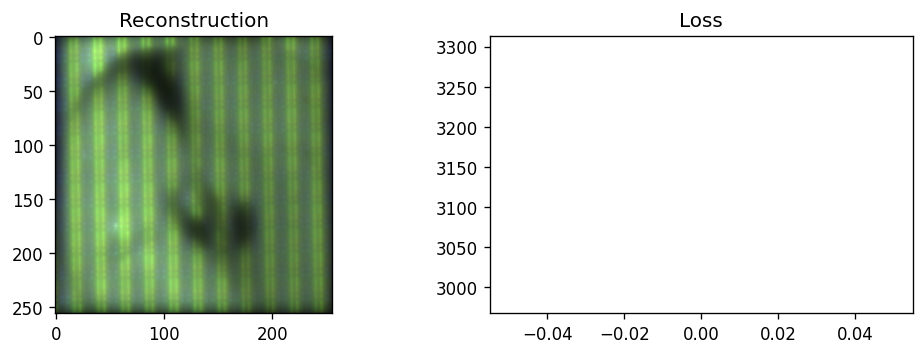

iteration:  390  loss:  tensor(5.1354, device='cuda:2', dtype=torch.float64)


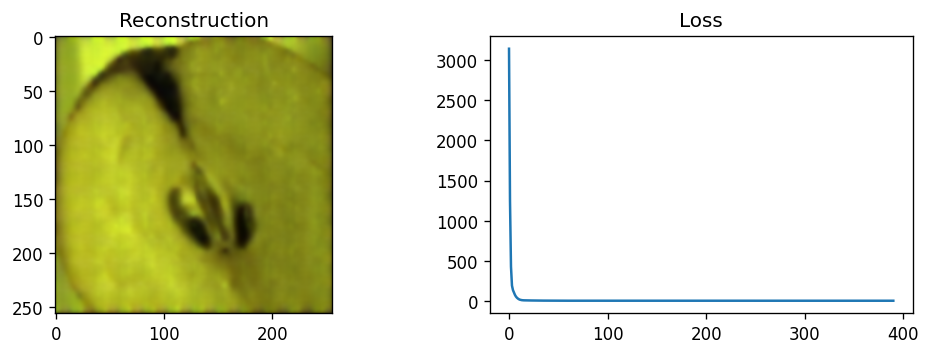

In [68]:
# perturb 0.01
model.model2.mask = perturb_mask(model.model1.mask, 0.01)
recon_001 = model(gt[None,None,...].to(device))

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


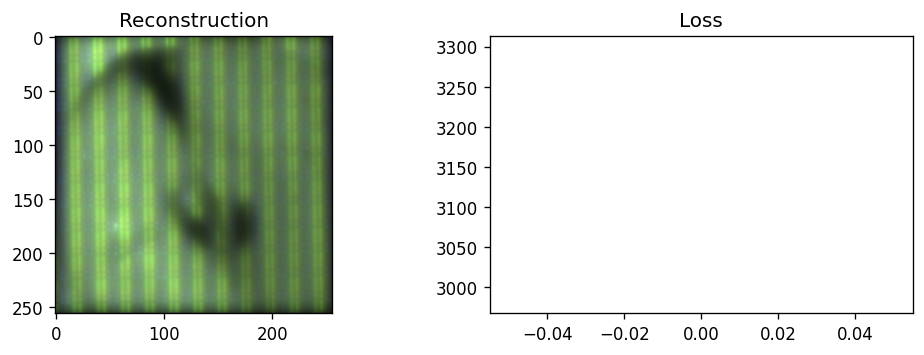

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  390  loss:  tensor(14.9633, device='cuda:2', dtype=torch.float64)


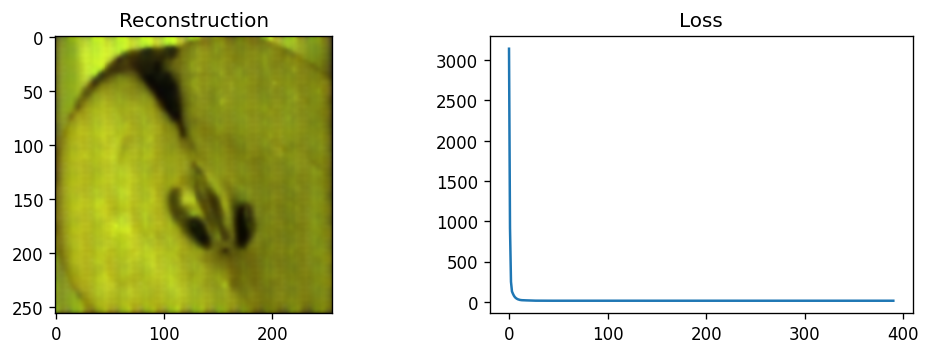

In [69]:
# perturb 0.02
model.model2.mask = perturb_mask(model.model1.mask, 0.02)
recon_002 = model(gt[None,None,...].to(device))

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


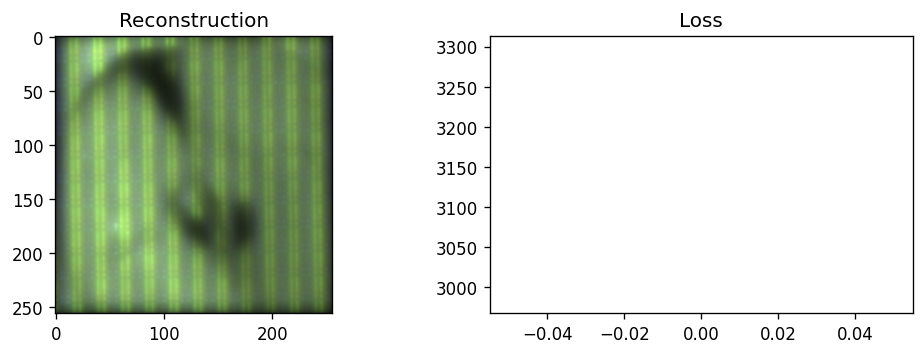

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  390  loss:  tensor(38.0568, device='cuda:2', dtype=torch.float64)


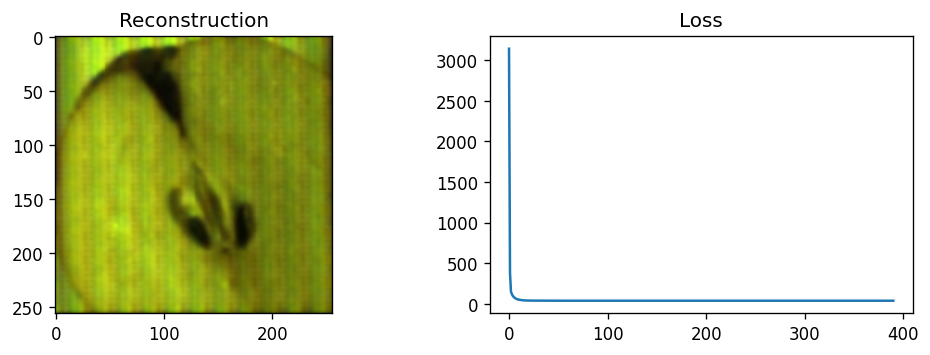

In [94]:
# perturb 0.04
model.model2.mask = perturb_mask(model.model1.mask, 0.04)
recon_004 = model(gt[None,None,...].to(device))

iteration:  0  loss:  tensor(3140.3089, device='cuda:2', dtype=torch.float64)


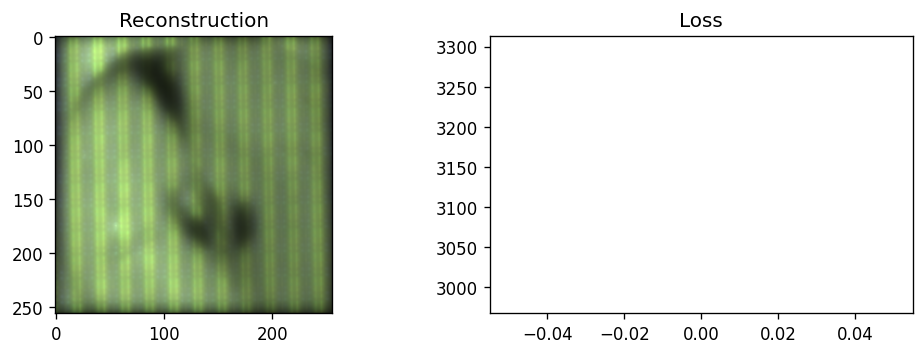

iteration:  390  loss:  tensor(3.0628e+21, device='cuda:2', dtype=torch.float64)


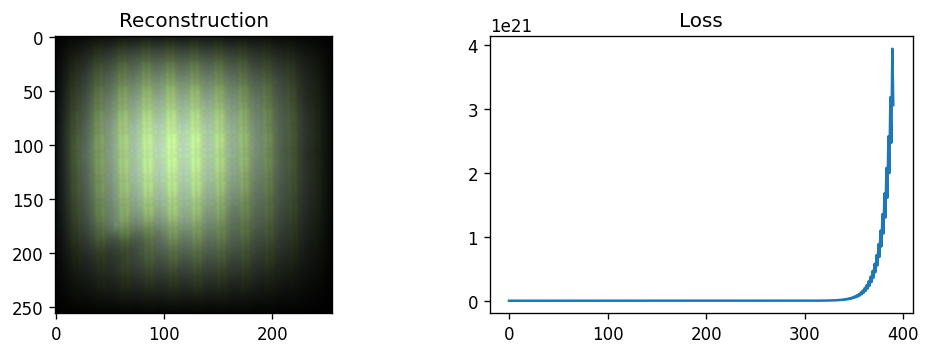

In [73]:
# perturb 0.10
model.model2.mask = perturb_mask(model.model1.mask, 0.08)
recon_008 = model(gt[None,None,...].to(device))

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


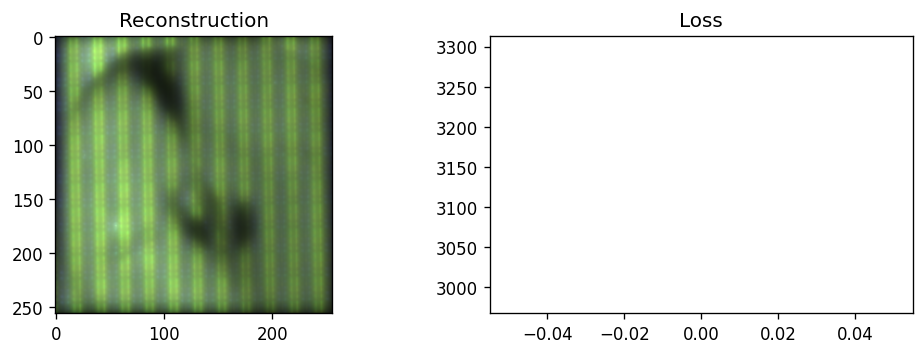

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  390  loss:  tensor(52.7944, device='cuda:2', dtype=torch.float64)


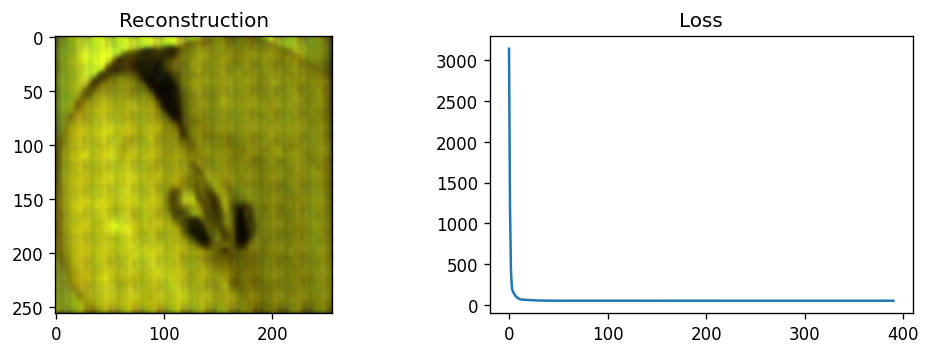

In [87]:
# perturb 0.04 but ONLY on low signal
perturb_mask_low = lambda x, y: torch.tensor(np.where(np.transpose(x[0].cpu().numpy(), (1,2,0)) > y, np.transpose(x[0].cpu().numpy(), (1,2,0)), y), device=device)

model.model2.mask = perturb_mask_low(model.model1.mask, 0.04)
recon_004_low = model(gt[None,None,...].to(device))

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


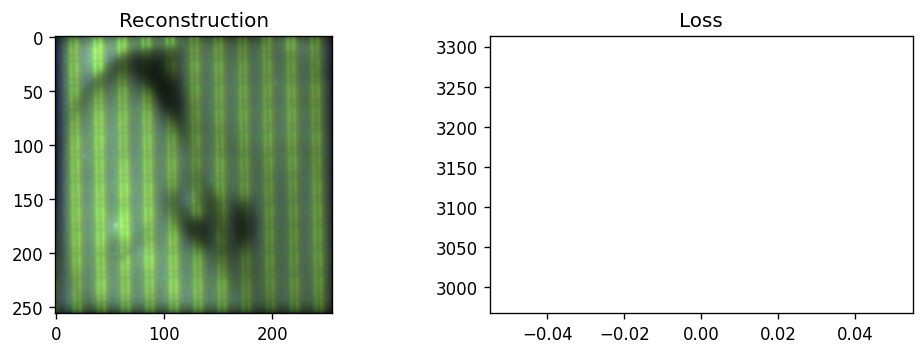

iteration:  390  loss:  tensor(8.4705, device='cuda:2', dtype=torch.float64)


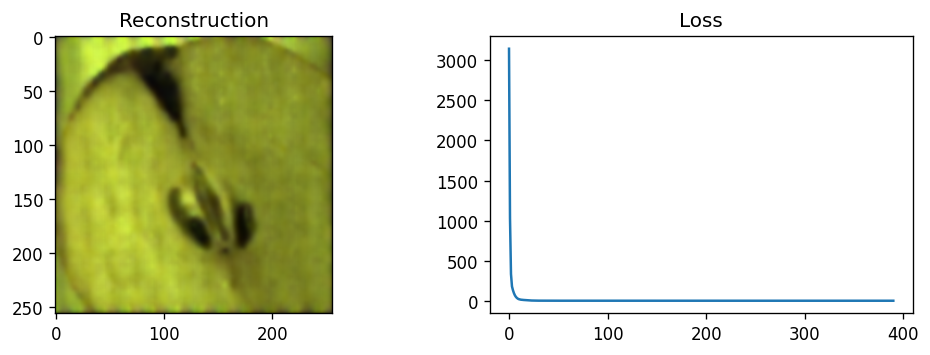

In [91]:
# perturb 0.04 but ONLY on high signal
perturb_mask_high = lambda x, y: torch.tensor(np.where(np.transpose(x[0].cpu().numpy(), (1,2,0)) < y, np.transpose(x[0].cpu().numpy(), (1,2,0)), np.transpose(x[0].cpu().numpy(), (1,2,0))+y), device=device)

model.model2.mask = perturb_mask_high(model.model1.mask, 0.04)
recon_004_high = model(gt[None,None,...].to(device))

In [96]:
helper.plot_cube_interactive(recon_004_low.cpu().numpy())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '34d8e594-8697-4789-8663-7438bec0bc67',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 49,  48,  15],
                           [ 57,  58,  22],
                           [ 63,  66,  25],
                           ..., 
                           [ 43,  36,  11],
                           [ 34,  27,   9],
                           [ 24,  19,   7]],
                   
                          [[ 58,  58,  20],
                           [ 67,  70,  29],
                           [ 74,  79,  33],
                           ..., 
                           [ 52,  45,  17],
                           [ 41,  35,  14],
                           [ 30,  24,  10]],
                   
                          [[ 64,  66,  23],
                           [ 74,  78,  32],
                           [ 81,  88,  35],
                           ..., 
                           [ 60,  54

In [92]:
helper.plot_cube_interactive(recon_004_high.cpu().numpy())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '8e8e8645-93aa-4be4-b009-9ebee23f656c',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 42,  42,  23],
                           [ 51,  52,  34],
                           [ 57,  61,  39],
                           ..., 
                           [ 51,  46,  27],
                           [ 41,  37,  22],
                           [ 32,  28,  15]],
                   
                          [[ 52,  53,  31],
                           [ 63,  66,  45],
                           [ 70,  76,  52],
                           ..., 
                           [ 62,  57,  36],
                           [ 51,  46,  30],
                           [ 40,  35,  22]],
                   
                          [[ 62,  62,  36],
                           [ 73,  77,  51],
                           [ 81,  87,  57],
                           ..., 
                           [ 70,  66

In [97]:
helper.plot_cube_interactive(recon_004.cpu().numpy())

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'b88ab9ad-e5f7-4b25-a3a6-bdfea12190e4',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 42,  38,  18],
                           [ 50,  49,  26],
                           [ 56,  58,  29],
                           ..., 
                           [ 46,  36,  11],
                           [ 35,  27,   9],
                           [ 26,  18,   7]],
                   
                          [[ 51,  48,  24],
                           [ 62,  62,  34],
                           [ 69,  72,  38],
                           ..., 
                           [ 56,  46,  18],
                           [ 44,  35,  15],
                           [ 32,  24,  11]],
                   
                          [[ 59,  56,  28],
                           [ 70,  70,  36],
                           [ 77,  80,  40],
                           ..., 
                           [ 65,  55

In [101]:
helper.plot_cube_interactive(model.model2.mask.cpu().numpy())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '376a598a-93ed-4e26-82a6-e9768cde998a',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 22,  25,   7],
                           [ 31,  38,  61],
                           [ 34,  38, 159],
                           ..., 
                           [ 13,  17,  23],
                           [ 14,  19,  16],
                           [ 16,  21,   9]],
                   
                          [[ 19,  21,   6],
                           [ 29,  42,  58],
                           [ 34,  62, 169],
                           ..., 
                           [ 13,  17,  23],
                           [ 14,  19,  16],
                           [ 15,  20,   9]],
                   
                          [[ 19,  22,   5],
                           [ 29,  41,  54],
                           [ 33,  59, 161],
                           ..., 
                           [ 28,  24

iteration:  0  loss:  tensor(3140.3088, device='cuda:2', dtype=torch.float64)


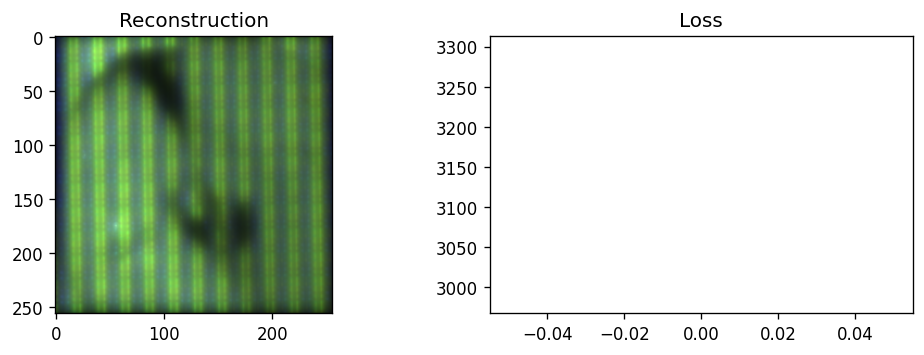

iteration:  390  loss:  tensor(86.2785, device='cuda:2', dtype=torch.float64)


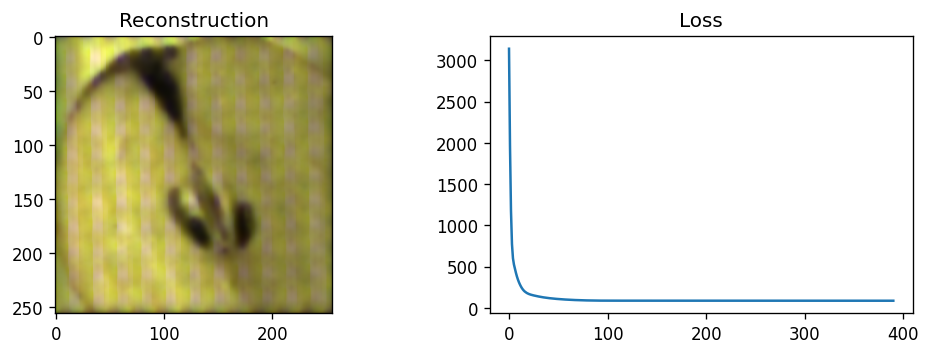

In [103]:
# perturb 0.04 but ONLY on low signal
perturb_mask_low = lambda x, y: torch.tensor(np.where(np.transpose(x[0].cpu().numpy(), (1,2,0)) > y, np.transpose(x[0].cpu().numpy(), (1,2,0)), y), device=device)
model.model2.mask = perturb_mask_low(model.model1.mask, 0.04)

# noisegate low signal
noise_threshold = 0.04
model.model2.mask = torch.tensor(np.where(model.model2.mask.cpu().numpy() <= 0.041, 0, model.model2.mask.cpu().numpy()), device=device)

recon_004_low = model(gt[None,None,...].to(device))